# **FDS - Final Project: Classification of Fake and Real Faces**

## **Testing on New Images**

In this notebook, we import images created by online AI image generators, and test if our model is able to detect that they are fake.

#### Import libraries

In [ ]:
pip install grad-cam

In [ ]:
!pip install torchcam

In [4]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import models
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import seaborn as sns
import cv2
from google.colab import drive
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import copy
from collections import defaultdict

Mount Google Drive for saving results later.

In [5]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

Mounted at /content/drive


Set random seeds for reproducibility of results.

In [6]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load New Fake Images

We generated some fake faces on https://www.freepik.com/ and https://designer.microsoft.com/image-creator, then saved them in a google drive folder: https://drive.google.com/drive/folders/1r8X90f4NV3kmQbjr8UG8eR7y5XT0kOrc.

We want to see if our trained CustomCNN can recognize fake faces even if they are not generated by StyleGAN.

In [7]:
import os
from PIL import Image

# Paths where the images are
Freepik_path = '/content/drive/MyDrive/NewImages/Freepik'
Microsoft_path = '/content/drive/MyDrive/NewImages/Microsoft-Designer'

# Lists to store images
freepik_images = []
microsoft_images = []

# Function to load jpeg images from a drive
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpeg')): # look for jpeg files
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                images.append(img)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
    return images

# Load images into respective lists
freepik_images = load_images_from_directory(Freepik_path)
microsoft_images = load_images_from_directory(Microsoft_path)

We can see if the images got saved.

In [8]:
# Output the results
print(f'Loaded {len(freepik_images)} images from Freepik.')
print(f'Loaded {len(microsoft_images)} images from Microsoft.')

Loaded 34 images from Freepik.
Loaded 44 images from Microsoft.


Let us visualize some images

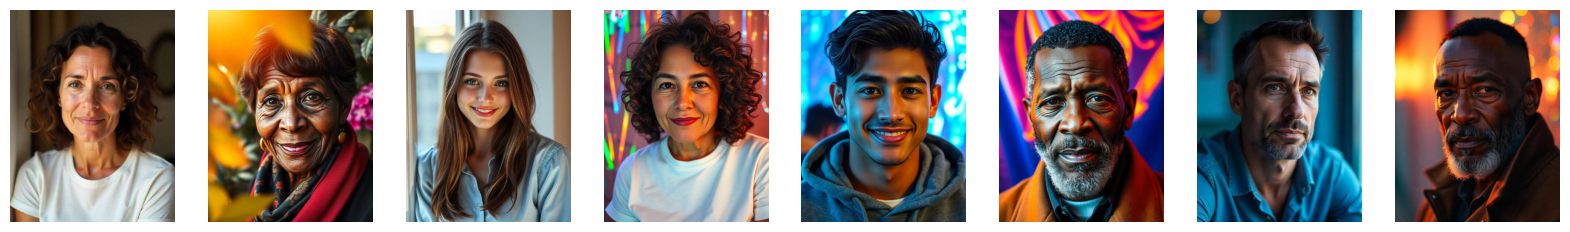

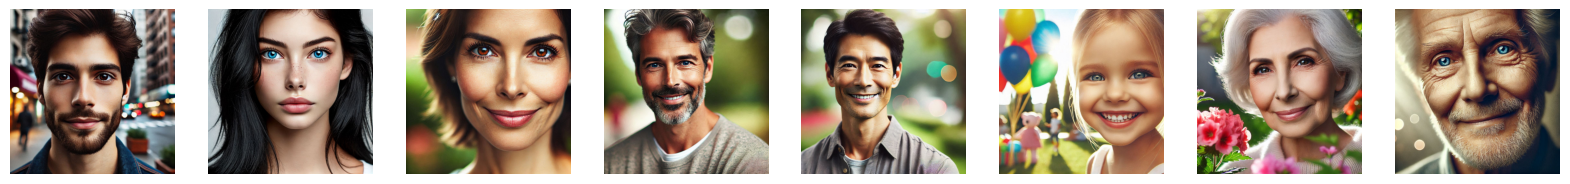

In [9]:
def visualize_images(image_list, title, max_images=5):
    '''
    Function to visualize images from a list with a specified title and maximum number of images to display
    Args:
        image_list (list): list of images
        title (str): title for the visualization
        max_images (int): maximum number of images to display
    '''
    num_images = min(len(image_list), max_images)
    plt.figure(figsize=(20, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_list[i])
        plt.axis('off')
        #plt.title(f'{title} {i+1}')

    plt.show()

# Visualize images from Freepik
visualize_images(freepik_images, 'Freepik Image', 8)

# Visualize images from Microsoft
visualize_images(microsoft_images, 'Microsoft Image', 8)

These images generated with Freepik and Microsoft Designer are visibly different from those generated by Style-GAN. For the human eye it might be easier to tell these apart from real images, so we want to see if our CustomCNN can do it too.

### Custom CNN

Here is the architecture of the Custom CNN we built:

In [10]:
class CustomCNN(nn.Module):

    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 64 filters, 3x3 kernel
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization

        # ReLU activation
        self.relu = nn.ReLU()

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 128 filters
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization

        # Third Convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # 256 filters
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization

        # Fourth Convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # 512 filters
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization

        # Flatten Layer: Converts 2D feature map into 1D vector
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layer 1: 512 neurons
        self.fc1 = nn.Linear(256 * 32 * 32, 512)

        # Fully Connected Layer 2: 256 neurons
        self.fc2 = nn.Linear(512, 256)

        # Fully Connected Layer 3: 2 neurons
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        # First Convolutional layer
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # Second Convolutional layer
        x = self.relu(self.bn2(self.conv2(x)))

        # Third Convolutional layer
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # Fourth Convolutional layer
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Flatten Layer
        x = self.flatten(x)

        # Fully Connected Layer 1
        x = self.dropout(self.relu(self.fc1(x)))

        # Fully Connected Layer 2
        x = self.dropout(self.relu(self.fc2(x)))

        # Output Layer
        x = self.fc3(x)

        return x



Here we define transformations to pass the input images to our model. We also define a transform for data augmentation purposes, which will be used later. `model = CustomCNN()` initializes the CNN.

In [11]:
# Specify input transformations to pass it to the model
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image if needed
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Initialize the custom CNN
model = CustomCNN()

In [12]:
results_dict = torch.load('/content/drive/MyDrive/CustomCNN/results_CE_SGD_0001_mom.pth')
model_weights = results_dict['model_state_dict']
model.load_state_dict(model_weights)

<ipython-input-12-db2502ce8f97>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_dict = torch.load('/content/drive/MyDrive/CustomCNN/results_CE_SGD_0001_mom.pth')


<All keys matched successfully>

Next, we make training, validation, test dataset and dataloader instances:

Switch to GPU if available:

In [13]:
# Set device to cuda if it is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to the right device
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (

In [15]:
# Get predictions on Freepik images
for i, image in enumerate(freepik_images):
  img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

pred_fake_count = 0

for i, image in enumerate(freepik_images):
  img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
  with torch.no_grad():
      outputs = model(img_tensor)  # Compute output
      _, predicted = torch.max(outputs, 1) # Get prediction
      if predicted.item() == 0:
          pred_fake_count += 1

print(f'Predicted {pred_fake_count} fake images out of {len(freepik_images)} Freepik images')

# Get predictions on Microsoft images
for i, image in enumerate(microsoft_images):
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

pred_fake_count = 0

for i, image in enumerate(microsoft_images):
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        outputs = model(img_tensor)  # Compute output
        _, predicted = torch.max(outputs, 1) # Get prediction
        if predicted.item() == 0:
            pred_fake_count += 1

print(f'Predicted {pred_fake_count} fake images out of {len(microsoft_images)} Microsoft images')

Predicted 0 fake images out of 34 Freepik images
Predicted 0 fake images out of 44 Microsoft images


The model was unable to detect any of the fake images. This can probably be explained by the fact that it was trained on StyleGAN images, which work differently than diffusion models such as those behind the Freepik images here. Humans could clearly tell that the images above are fake, but a CNN trained on StyleGAN images struggles more, because these images have different properties from the StyleGAN generated fake faces. StyleGAN excels at creating highly realistic faces due to its focus on disentangled latent spaces, texture control, and training on high-quality face datasets. The outputs are rich in fine details, anatomical accuracy (usually), which makes them more lifelike compared to the colorful, smooth, and occasionally surreal images produced by diffusion models.

Unfortunately, we were unable to get access to more varied, large datasets from different sources. However, creating CNNs that are flexible enough to recognize real from fake faces regardless of the process that created them, would require training the model on a very large quantity of different images. With the increased presence of AI and deepfake technology, we hope for and support the creation of models able to detect truth from falsehood when it comes to things as important as human identity.